# Building a chatbot app in LangGraph: filtering and trimming messages

## Setup

#### After you download the code from the github repository in your computer
In terminal:
* cd project_name
* pyenv local 3.11.4
* poetry install
* poetry shell

#### To open the notebook with Jupyter Notebooks
In terminal:
* jupyter lab

Go to the folder of notebooks and open the right notebook.

#### To see the code in Virtual Studio Code or your editor of choice.
* open Virtual Studio Code or your editor of choice.
* open the project-folder
* open the 012-filter-trim-messages.py file

## Create your .env file
* In the github repo we have included a file named .env.example
* Rename that file to .env file and here is where you will add your confidential api keys. Remember to include:
* OPENAI_API_KEY=your_openai_api_key
* LANGCHAIN_TRACING_V2=true
* LANGCHAIN_ENDPOINT=https://api.smith.langchain.com
* LANGCHAIN_API_KEY=your_langchain_api_key
* LANGCHAIN_PROJECT=your_project_name

## Track operations
From now on, we can track the operations **and the cost** of this project from LangSmith:
* [smith.langchain.com](https://smith.langchain.com)

## Connect with the .env file located in the same directory of this notebook

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [1]:
#pip install python-dotenv

In [2]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())
openai_api_key = os.environ["OPENAI_API_KEY"]

#### Install LangChain

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [3]:
#!pip install langchain

## Connect with an LLM

If you are using the pre-loaded poetry shell, you do not need to install the following package because it is already pre-loaded for you:

In [4]:
#!pip install langchain-openai

In [5]:
from langchain_openai import ChatOpenAI

chatModel35 = ChatOpenAI(model="gpt-3.5-turbo-0125")
chatModel4o = ChatOpenAI(model="gpt-4o")

## Let's add a few messages to the app state

In [6]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(f"So you said you were researching about the Kennedys?", name="Bot")]

messages.append(HumanMessage(f"Yes, I know about JFK. But what others should I learn about?", name="Julio"))

In [7]:
chatModel4o.invoke(messages)

AIMessage(content='In addition to John F. Kennedy (JFK), there are several other notable members of the Kennedy family you might find interesting:\n\n1. **Robert F. Kennedy (RFK)**: JFK\'s younger brother, Robert served as the U.S. Attorney General from 1961 to 1964 and was a key advisor during JFK\'s presidency. He became a U.S. Senator from New York and was assassinated in 1968 while campaigning for the presidency.\n\n2. **Edward "Ted" Kennedy**: The youngest Kennedy brother, he served as a U.S. Senator from Massachusetts for nearly 47 years, becoming one of the most influential senators in American history through his work on health care, civil rights, and education.\n\n3. **Jacqueline Kennedy Onassis**: JFK\'s wife, Jackie was the First Lady from 1961 to 1963 and became an international icon of style and grace. After JFK\'s assassination, she married Greek shipping magnate Aristotle Onassis.\n\n4. **Joseph P. Kennedy Sr.**: The patriarch of the Kennedy family, Joseph was a prominen

## Let's create a simple chatbot with LangGraph

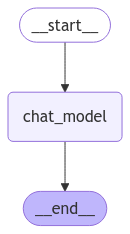

In [8]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

llm = ChatOpenAI(model="gpt-4o")

# Node: see how we use the built-in MessagesState
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
output = graph.invoke({'messages': messages})

for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching about the Kennedys?
================================ Human Message =================================
Name: Julio

Yes, I know about JFK. But what others should I learn about?
================================== Ai Message ==================================

The Kennedy family is a prominent American political family known for its significant contributions to politics, public service, and business. Beyond John F. Kennedy (JFK), here are some other notable members you might want to learn about:

1. **Joseph P. Kennedy Sr.**: The patriarch of the Kennedy family, Joseph was a successful businessman and served as the U.S. Ambassador to the United Kingdom. He played a crucial role in shaping the political aspirations of his children.

2. **Rose Kennedy**: The matriarch of the family, Rose was deeply involved in her children's lives and was known for her strong Catholic 

## Techniques to prevent high token usage in a conversation with a chatbot
* Long-running conversations result in high token usage because the user can pass a growing list of messages to the model.

#### Technique #1: Use a reducer to keep only the last messages in memory
* Using RemoveMessage and the add_messages reducer.

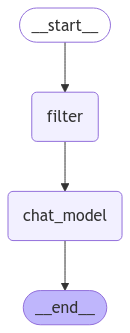

In [10]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)

builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

#### What does the previous function filter_messages do?

The function `filter_messages` processes a collection of messages stored in the `MessagesState` object. Here's a step-by-step explanation in simple terms:

1. **Input**: The function takes one input, `state`, which is expected to be an object containing a list of messages under the key `"messages"`.

2. **Goal**: The goal is to delete all but the two most recent messages.

3. **Logic**:
   - The line `state["messages"][:-2]` selects all messages except the last two in the list. This is done using Python slicing.
   - A list comprehension is used to create a new list called `delete_messages`. For each message in the sliced list, it creates a `RemoveMessage` object with the `id` of the message to mark it for deletion.

4. **Output**:
   - The function returns a dictionary with a key `"messages"` containing the list of `RemoveMessage` objects. These objects represent the messages that should be deleted.

#### Example in Practice
Suppose the `state` object contains the following messages:

```python
state = {
    "messages": [
        {"id": 1, "content": "Hello"},
        {"id": 2, "content": "How are you?"},
        {"id": 3, "content": "I'm good."},
        {"id": 4, "content": "What about you?"}
    ]
}
```

- The slicing `state["messages"][:-2]` selects the first two messages (`id=1` and `id=2`).
- The function creates `RemoveMessage` objects for these messages:
  ```python
  [
      RemoveMessage(id=1),
      RemoveMessage(id=2)
  ]
  ```
- The output will be:
  ```python
  {"messages": [RemoveMessage(id=1), RemoveMessage(id=2)]}
  ```
This tells the system to delete the first two messages, keeping only the last two. This **output alone does not modify the state of the messages**. It is just a list of instructions indicating which messages should be removed. The actual deletion would need to happen next based on this output.

Once LangGraph processes the output of the function and removes the specified messages (`id=1` and `id=2`) from the original `state`, then the final state of the messages would contain only the last two messages:

```python
[
    {"id": 3, "content": "I'm good."},
    {"id": 4, "content": "What about you?"}
]
```

LangGraph uses the `RemoveMessage` objects to delete messages from `state["messages"]`. 

In [11]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Julio", id="2"))
messages.append(AIMessage("So you said you were researching on the Kennedys?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about JFK. But what others should I learn about?", name="Julio", id="4"))

# Invoke
output = graph.invoke({'messages': messages})

for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching on the Kennedys?
================================ Human Message =================================
Name: Julio

Yes, I know about JFK. But what others should I learn about?
================================== Ai Message ==================================

Aside from John F. Kennedy, there are several other notable members of the Kennedy family you might be interested in learning about:

1. **Robert F. Kennedy (RFK)** - JFK's younger brother who served as the U.S. Attorney General from 1961 to 1964 and later as a U.S. Senator from New York. He was a prominent advocate for civil rights and social justice and was assassinated in 1968 while running for the Democratic presidential nomination.

2. **Edward "Ted" Kennedy** - The youngest Kennedy brother who served as a U.S. Senator from Massachusetts for nearly 47 years, from 1962 until his death in 2009. He played a sign

#### Technique #2: Filter only the last message in memory
* With this option you do not delete the previous messages.
* The state has all of the mesages.
* But only the filtered messages were sent to the LLM.
* If you look in LangSmith, you will see see that the model invocation only uses the last message.

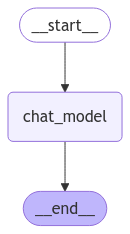

In [12]:
# Node
# Filter only the last message of the state
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

#### Explanation

In the previous code we extracted the **last message** from the list stored in the `state` object. Here's how it works, step by step:

1. **`state["messages"]`**: This accesses a value in the dictionary `state` using the key `"messages"`. It assumes that `state["messages"]` is a list (like `[msg1, msg2, msg3, ...]`).

2. **`[-1:]`**: This is **Python list slicing**. The `-1` means "start from the last item of the list", and the `:` means "take everything up to the end." 
   - Instead of returning just the last item, this returns a **list containing the last item**. 

#### Example

```python
state = {
    "messages": ["Hello", "How are you?", "Goodbye"]
}

# Extract the last message as a list
last_message = state["messages"][-1:]

print(last_message)  # Output: ['Goodbye']
```

Keep in mind that we did not use `state["messages"][-1]`. That would extract only the last item of the list, but the result will not be a list. Here's why:

- **`state["messages"][-1]`**: This retrieves **only the last item** from the list, but the result will be the item itself, not a list.

- **`state["messages"][-1:]`**: This retrieves the **last item as a new list containing that single item**. It's a slice of the list starting from the last element, so it keeps the result in list form.

In [25]:
messages.append(HumanMessage(f"This is my last message. What was our previous conversation about?", name="Julio"))

# Invoke
output = graph.invoke({'messages': messages})

for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Julio

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching on the Kennedys?
================================ Human Message =================================
Name: Julio

Yes, I know about JFK. But what others should I learn about?
================================ Human Message =================================
Name: Julio

This is my last message. What was our previous conversation about?
================================ Human Message =================================
Name: Julio

This is my last message. What was our previous conversation about?
================================== Ai Message ==================================

I'm sorry, but I can't recall previous conversations. However, if you provide some context or details, I'

* **As you can see, even when the LLM prints the whole conversation, the current state has filtered all but the last message, so it does not have memory of our previous conversation**.

#### Technique #3: Use a reducer to trim the number of tokens in the state
* This restricts the message history to a specified number of tokens.

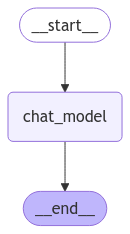

In [23]:
from langchain_core.messages import trim_messages

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=25,
            # see the difference with:
            # max_tokens=100,
            strategy="last",
            token_counter=ChatOpenAI(model="gpt-4o"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)

builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

## Let's explain the previous function in simple terms

In the previous code we defined a function called `chat_model_node` that processes a conversation's messages in a specific way and returns a response. Let’s break it down step by step:

#### Function Definition
```python
def chat_model_node(state: MessagesState):
```
- The function `chat_model_node` takes one input parameter, `state`, which is expected to be an instance of `MessagesState`.
- `state` contains the conversation's messages in some structured format.

#### Trimming Messages
```python
messages = trim_messages(
    state["messages"],
    max_tokens=25,
    strategy="last",
    token_counter=ChatOpenAI(model="gpt-4o"),
    allow_partial=False,
)
```
- **`trim_messages`**: A function that reduces the size of the conversation messages to meet certain constraints.
- **Parameters**:
  - `state["messages"]`: The current conversation messages.
  - `max_tokens=25`: Limits the size of the messages to a maximum of 25 tokens (a token is roughly a word or part of a word).
    - There's a commented-out alternative (`max_tokens=100`) to allow up to 100 tokens instead.
  - `strategy="last"`: Keeps only the most recent messages if the conversation is too long.
  - `token_counter=ChatOpenAI(model="gpt-4o")`: Uses the `gpt-4o` model to count the number of tokens in the messages.
  - `allow_partial=False`: Ensures that messages aren’t partially truncated; only full messages are included.

#### Returning the Response
```python
return {"messages": [llm.invoke(messages)]}
```
- After trimming, the function prepares a response:
  - **`llm.invoke(messages)`**: Sends the trimmed messages to a language model (likely a GPT-based model) and gets the response.
  - **`{"messages": [...]}`**: Packages the response from the model in a dictionary under the `"messages"` key.

#### Summary
- The function `chat_model_node` processes conversation messages by trimming them to a manageable size (based on the token limit and strategy).
- It then sends the trimmed messages to a language model for a response.
- The final output is a dictionary containing the model's response.

In [24]:
# Invoke
output = graph.invoke({'messages': messages})

for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Julio

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching on the Kennedys?
================================ Human Message =================================
Name: Julio

Yes, I know about JFK. But what others should I learn about?
================================ Human Message =================================
Name: Julio

This is my last message. What was our previous conversation about?
================================== Ai Message ==================================

I'm sorry, but I can't recall previous conversations. Could you remind me what we were discussing?


* **Execute the previous two cells with max-token=100 to see the difference. With max-token=100 the LLM remembers our previous conversation because it has it in the state.**

## How to execute the code from Visual Studio Code
* In Visual Studio Code, see the file 012-filter-trim-messages.py
* In terminal, make sure you are in the directory of the file and run:
    * python 012-filter-trim-messages.py